# Creating the initial conditions

In [1]:
from roms_tools import Grid

We start by creating a grid.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20
)

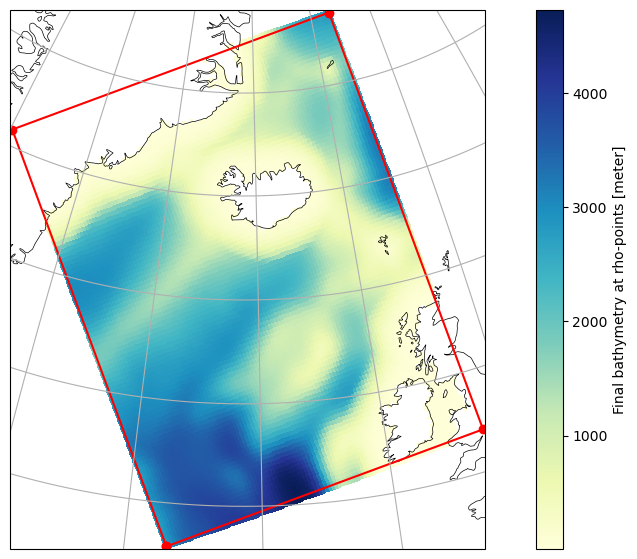

In [3]:
grid.plot(bathymetry=True)

## Initial conditions from GLORYS
In this section, we use GLORYS data to create our initial conditions. Say we want to get initial conditions for January 2, 2012.

In [4]:
from datetime import datetime

ini_time = datetime(2012, 1, 2)

Our GLORYS data for that day sits at the following path.

In [5]:
filename = "/glade/derecho/scratch/bachman/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc"

Note that it would also be okay to provide a filename that contains data for more than just the day of interest. `ROMS-Tools` will pick out the correct day (and complain if the day of interest is not in the provided filename.) Or we can even use wildcards, such as `filename='/glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc'`.

We can now create the `InitialConditions` object.

In [6]:
from roms_tools import InitialConditions

In [7]:
%%time
ic = InitialConditions(
    grid=grid,  # grid object
    ini_time=ini_time,  # initialization date
    source="glorys",  # source of the initial condition data
    filename=filename,  # path to the source data file
    N=100,  # number of vertical levels
    theta_s=5.0,  # surface control parameter
    theta_b=2.0,  # bottom control parameter
    hc=300.0,  # critical depth
)

CPU times: user 7.93 s, sys: 212 ms, total: 8.14 s
Wall time: 9.17 s


The parameters `N`, `theta_s`, `theta_b`, and `hc` determine the vertical coordinate system, which is constructed according Shchepetkin and McWilliams (2009), see also Figure 2 in Lemarie, et al., 2012.

The initial conditions variables are held in an xarray Dataset that is accessible via the `.ds` property.

In [8]:
ic.ds

<xarray.Dataset> Size: 34MB
Dimensions:     (time: 1, eta_v: 101, xi_rho: 102, eta_rho: 102, s_rho: 100,
                 xi_u: 101, s_w: 101)
Coordinates:
  * time        (time) datetime64[ns] 8B 2012-01-02T12:00:00
    lat_rho     (eta_v, xi_rho) float64 82kB 48.04 48.1 48.17 ... 73.51 73.53
    lon_rho     (eta_v, xi_rho) float64 82kB 332.9 333.1 333.4 ... 352.6 353.2
    lat_u       (eta_rho, xi_u) float64 82kB 47.87 47.94 48.0 ... 73.5 73.52
    lon_u       (eta_rho, xi_u) float64 82kB 333.2 333.4 333.6 ... 352.4 352.9
    lat_v       (eta_v, xi_rho) float64 82kB 47.94 48.0 48.07 ... 73.4 73.42
    lon_v       (eta_v, xi_rho) float64 82kB 333.0 333.2 333.4 ... 352.7 353.2
    depth_rho   (eta_rho, xi_rho, s_rho) float32 4MB 2.864e+03 ... 1.378
    depth_u     (eta_rho, xi_u, s_rho) float32 4MB 2.864e+03 2.817e+03 ... 1.378
    depth_v     (eta_v, xi_rho, s_rho) float32 4MB 2.864e+03 2.817e+03 ... 1.378
    ocean_time  (time) float32 4B 3.788e+08
Dimensions without coordinates: eta_v, xi_rho, eta_rho, s_rho, xi_u, s_w
Data variables: (12/14)
    temp        (time, eta_rho, xi_rho, s_rho) float32 4MB dask.array<chunksize=(1, 102, 102, 100), meta=np.ndarray>
    salt        (time, eta_rho, xi_rho, s_rho) float32 4MB dask.array<chunksize=(1, 102, 102, 100), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 42kB -0.4969 -0.481 ... -0.9301
    u           (time, eta_rho, xi_u, s_rho) float32 4MB dask.array<chunksize=(1, 102, 101, 100), meta=np.ndarray>
    v           (time, eta_v, xi_rho, s_rho) float32 4MB dask.array<chunksize=(1, 101, 102, 100), meta=np.ndarray>
    w           (time, eta_rho, xi_rho, s_w) float32 4MB 0.0 0.0 0.0 ... 0.0 0.0
    ...          ...
    theta_s     float32 4B 5.0
    theta_b     float32 4B 2.0
    Tcline      float32 4B 300.0
    hc          float32 4B 300.0
    sc_r        (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.015 -0.005
    Cs_r        (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
Attributes:
    Title:    ROMS initial file produced by roms-tools

You can see that all initial conditions variables are Dask arrays, so these fields have not been actually computed yet. An exception is the variable `zeta`, which has been computed to check for NaNs in the interpolated fields, and the variable `w`, which is set to zero. Full computation will not be triggered until the `.plot` or `.save` methods are called.

## Plotting

Let's make some plots! As an example, let's have a look at the temperature field `temp`. It is three-dimensional with horizontal dimensions `eta_rho` and `xi_rho`, and vertical dimension `s_rho`.

In [9]:
ic.ds.temp

<xarray.DataArray 'temp' (time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100)> Size: 4MB
dask.array<astype, shape=(1, 102, 102, 100), dtype=float32, chunksize=(1, 102, 102, 100), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 8B 2012-01-02T12:00:00
    depth_rho   (eta_rho, xi_rho, s_rho) float32 4MB 2.864e+03 ... 1.378
    ocean_time  (time) float32 4B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho
Attributes:
    long_name:  Potential temperature
    units:      Celsius

We first want to plot different layers of the temperature field, i.e., slice along the vertical dimension `s_rho`.

CPU times: user 53.7 s, sys: 498 ms, total: 54.2 s
Wall time: 58.7 s


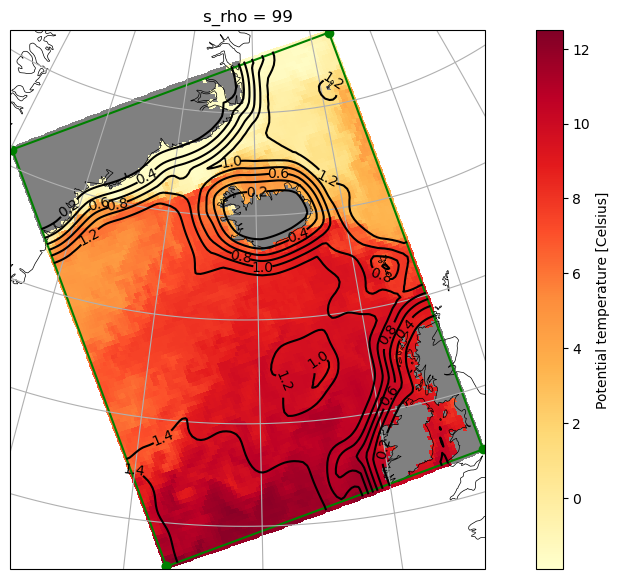

In [10]:
%time ic.plot("temp", s_rho=-1, depth_contours=True)  # plot uppermost layer

Note that this took some time because the computation of the three-dimensional temperature field was triggered before plotting. Indeed, the temperature values are now fully computed (and don't need to be re-computed when calling the `.plot` or `.save` methods).

In [11]:
ic.ds.temp

<xarray.DataArray 'temp' (time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100)> Size: 4MB
array([[[[ 3.2133336 ,  3.2133336 ,  3.2133336 , ..., 11.861317  ,
          11.861317  , 11.861317  ],
         [ 2.8887794 ,  2.9167864 ,  2.9459798 , ..., 11.975734  ,
          11.975734  , 11.975734  ],
         [ 2.835159  ,  2.8394558 ,  2.843969  , ..., 12.094538  ,
          12.094538  , 12.094538  ],
         ...,
         [ 8.045102  ,  8.045077  ,  8.045053  , ...,  8.0427065 ,
           8.042685  ,  8.042663  ],
         [ 8.14938   ,  8.149358  ,  8.149337  , ...,  8.147175  ,
           8.147154  ,  8.147133  ],
         [ 8.375315  ,  8.375298  ,  8.37528   , ...,  8.373467  ,
           8.373449  ,  8.373431  ]],

        [[ 2.927417  ,  2.939567  ,  2.9522321 , ..., 12.0453415 ,
          12.0453415 , 12.045038  ],
         [ 2.8645372 ,  2.884021  ,  2.9043305 , ..., 12.128715  ,
          12.128715  , 12.128336  ],
         [ 2.9462984 ,  2.9462984 ,  2.9462984 , ..., 12.21467   ,
          12.21467   , 12.21467   ],
...
         [-0.9963152 , -0.9950389 , -0.9937087 , ..., -0.5203094 ,
          -0.5207716 , -0.5212487 ],
         [-1.0010488 , -0.9992769 , -0.99743   , ..., -0.5480129 ,
          -0.5480129 , -0.54781103],
         [-1.0041753 , -1.0013474 , -0.9983999 , ..., -0.6815782 ,
          -0.68099326, -0.6808458 ]],

        [[-1.2862183 , -1.2862204 , -1.2862226 , ..., -1.2875129 ,
          -1.2875314 , -1.2875499 ],
         [-1.2359356 , -1.2359389 , -1.2359424 , ..., -1.2373762 ,
          -1.2373962 , -1.2374161 ],
         [-1.1889087 , -1.1889133 , -1.188918  , ..., -1.1904925 ,
          -1.190514  , -1.1905353 ],
         ...,
         [-1.006307  , -1.0014566 , -0.9964013 , ..., -0.6358748 ,
          -0.6358841 , -0.6358841 ],
         [-1.0111945 , -1.0061735 , -1.0009403 , ..., -0.6390127 ,
          -0.6390127 , -0.6392241 ],
         [-1.0104384 , -1.0060076 , -1.0013894 , ..., -0.64388454,
          -0.6442147 , -0.6443343 ]]]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 8B 2012-01-02T12:00:00
    depth_rho   (eta_rho, xi_rho, s_rho) float32 4MB 2.864e+03 ... 1.378
    ocean_time  (time) float32 4B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho
Attributes:
    long_name:  Potential temperature
    units:      Celsius

Now plotting of the temperature field should be a lot faster.

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 132 ms


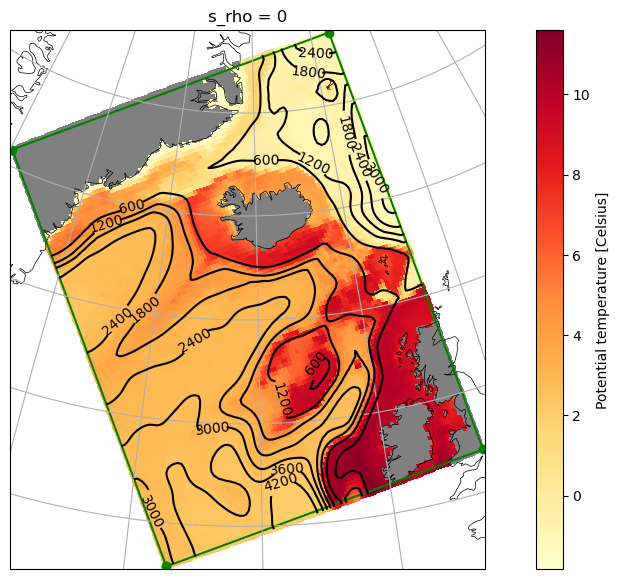

In [12]:
%time ic.plot("temp", s_rho=0, depth_contours=True)  # plot bottom layer

Next, we slice our domain along one of the horizontal dimensions and look at temperature along these sections.

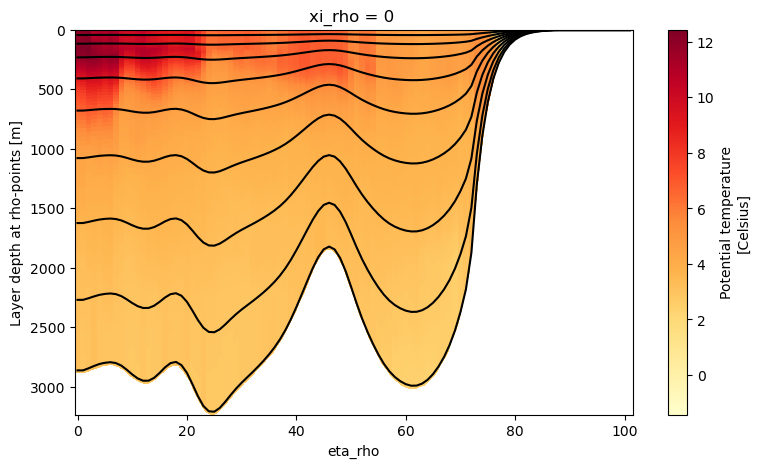

In [13]:
ic.plot("temp", xi=0, layer_contours=True)

Note that even though we have a total of 100 layers, `layer_contours = True` only plots a maximum of 10 contours to ensure plot clarity.

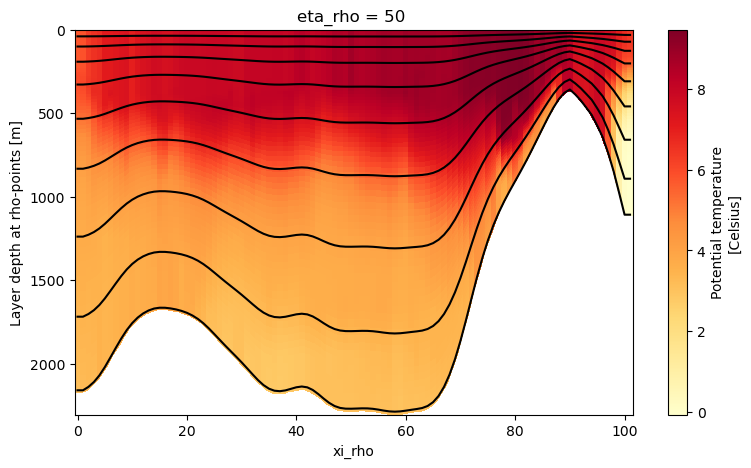

In [14]:
ic.plot("temp", eta=50, layer_contours=True)

We can also plot a depth profile at at certain spatial location.

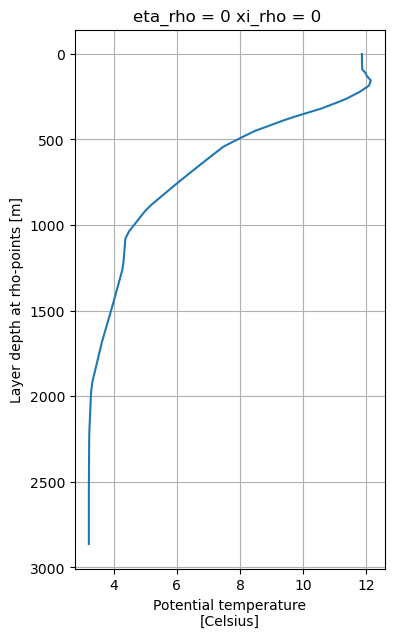

In [15]:
ic.plot("temp", eta=0, xi=0)

## Saving as NetCDF file

We can now save the dataset as a NetCDF file.

In [16]:
path = "/glade/derecho/scratch/noraloose/initial_conditions/ic_Iceland.nc"

In [17]:
from dask.diagnostics import ProgressBar

In [18]:
with ProgressBar():
    %time ic.save(filepath=path)

[########################################] | 100% Completed | 102.26 s
CPU times: user 1min 27s, sys: 1.58 s, total: 1min 28s
Wall time: 1min 42s
